In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from matplotlib.image import imread


In [2]:
path_to_directory='/home/varun/Desktop/celeba'

In [3]:
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision import datasets

In [4]:
batch_size=256
img_size=32
def data_loader_creater(batch_size,img_size):
    
    transformer=transforms.Compose([transforms.Resize(img_size), transforms.CenterCrop(img_size), transforms.ToTensor()])
    dataset=datasets.ImageFolder(path_to_directory,transform=transformer)

    data_loader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
    return data_loader

In [5]:
celeb_data_loader=data_loader_creater(batch_size,img_size)

In [6]:
type(celeb_data_loader)

torch.utils.data.dataloader.DataLoader

In [7]:
def img_show(img):
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

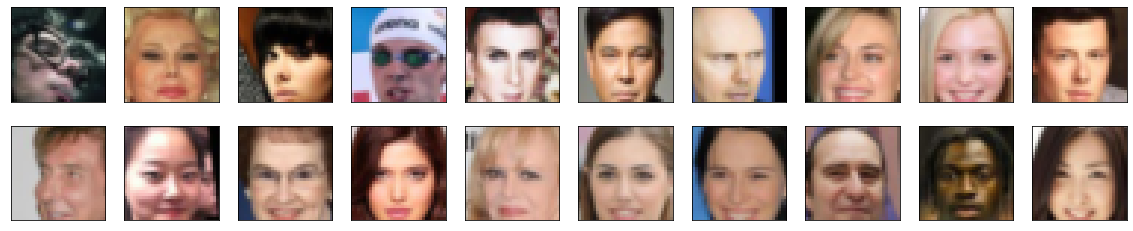

In [8]:
dataiter = iter(celeb_data_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    img_show(images[idx])



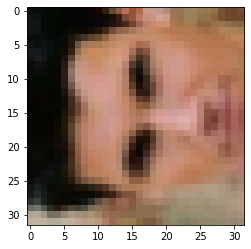

In [9]:
imag=images[250]
plt.imshow(np.transpose(imag.numpy()))

In [10]:
print(len(images))

256


In [11]:
#PreProcessing of images for TanH activatiomn function
def scaled_image(img):
    min=-1.0
    max=1.0
    img=img*(max-min)+min
    return img
    

In [12]:
img=images[250]
img=scaled_image(img)

In [13]:
img.min()

tensor(-1.)

In [14]:
img.max()

tensor(0.7569)

In [15]:
import torch.nn as nn
import torch.nn.functional as fn

In [16]:
conv_dim=64
reduce_dim=100
layers=[]

In [17]:
def G_conv(input_c,outpu_c,kernel_size,strides=2,padding=1,batch_norm=True):
    layers=[]
    con=nn.ConvTranspose2d(input_c,outpu_c,kernel_size,strides,padding,bias=False)
    layers.append(con)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(outpu_c))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self,reduce_dim,conv_dim):
        super(Generator,self).__init__()
        self.conv_dim=conv_dim
        self.layer_1=nn.Linear(reduce_dim,conv_dim*8*2*2)
#         self.layer_2=nn.ConvTranspose2d(conv_dim*16,conv_dim*8,kernel_size=4,stride=(2,2),padding=1,bias=False)
#         self.layer_2=G_conv(conv_dim*16,conv_dim*8,2)
        self.layer_3=G_conv(conv_dim*8,conv_dim*4,4)
        self.layer_4=G_conv(conv_dim*4,conv_dim*2,4)
        self.layer_5=G_conv(conv_dim*2,conv_dim,4)
        self.layer_6=G_conv(conv_dim,3,4,batch_norm=False)
        
    def forward(self,x):
        x=self.layer_1(x)
        x=x.view(-1,self.conv_dim*8,2,2)
#         x=fn.relu(self.layer_2(x))
        x=fn.relu(self.layer_3(x))
        x=fn.relu(self.layer_4(x))
        x=fn.relu(self.layer_5(x))
        x=torch.tanh(self.layer_6(x))
        return x


In [18]:
def D_conv(input_c,outpu_c,kernel_size,strides=2,padding=1,batch_norm=True):
    layers=[]
    con=nn.Conv2d(input_c,outpu_c,kernel_size,strides,padding,bias=False)
    layers.append(con)
    
    if (batch_norm):
        layers.append(nn.BatchNorm2d(outpu_c))
    return nn.Sequential(*layers)

In [19]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        self.conv_dim=conv_dim
        self.layer_1=D_conv(3,conv_dim,4,batch_norm=False)
        self.layer_2=D_conv(conv_dim,conv_dim*2,4)
        self.layer_3=D_conv(conv_dim*2,conv_dim*4,4)
#         self.layer_4=D_conv(conv_dim*4,conv_dim*8,2)
        self.fc=nn.Linear(conv_dim*4*4*4,1)
        

        
    def forward(self,x):
        x=fn.leaky_relu(self.layer_1(x))
        x=fn.leaky_relu(self.layer_2(x))
        x=fn.leaky_relu(self.layer_3(x))
#         x=fn.leaky_relu(self.layer_4(x))
        x=x.view(-1,self.conv_dim*4*4*4)
        x=self.fc(x)

        return x


In [20]:
generator=Generator(reduce_dim,conv_dim)
discriminator=Discriminator(conv_dim)


In [21]:

## The fucntion is imported from the Toward data science article for 
def weights_init_normal(m):
   
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if hasattr(m,'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        
        m.weight.data.normal_(0.0,0.02)
    
        if hasattr(m,'bias') and m.bias is not None:
            m.bias.data.zero_()

In [22]:
discriminator.apply(weights_init_normal)
generator.apply(weights_init_normal)

Generator(
  (layer_1): Linear(in_features=100, out_features=2048, bias=True)
  (layer_3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_5): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_6): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [23]:
# print(generator)

In [24]:
print(discriminator)

Discriminator(
  (layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)


In [25]:
import torch

In [26]:
train_on_gpu=torch.cuda.is_available()

if not train_on_gpu:
    print("GPU not avaliable")
else:
    print("GPU is avaliable: Training On GPU")

GPU is avaliable: Training On GPU


In [27]:
import torch.optim as optim

In [28]:
d_optimizer=optim.Adamax(discriminator.parameters(),lr=0.002 , betas=[0.5,0.99])
g_optimizer=optim.Adamax(generator.parameters(),lr=0.02,betas=[0.5,0.99])

In [29]:
def real_loss(disc_img):
    batch_sizee=disc_img.size(0)
    labels=torch.ones(batch_sizee)
    if train_on_gpu:
        labels=labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(disc_img.squeeze(),labels)
    
    return loss

In [30]:
def fake_loss(gen_img):
    batch_sizee=gen_img.size(0)
    labels=torch.zeros(batch_sizee)
    if train_on_gpu:
        labels=labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss=criterion(gen_img.squeeze(),labels)
    return loss

In [31]:
def train(discriminator,generator,epochs):
    if train_on_gpu:
        discriminator.cuda()
        generator.cuda()
    sample=[]
    loss=[]
    
    sample_size=16
    fixed_z=np.random.uniform(-1,1,size=(batch_size,reduce_dim))
    fixed_z=torch.from_numpy(fixed_z).float()
    
    if train_on_gpu:
        fixed_z=fixed_z.cuda()
        
        
    for epoch in range(epochs):
        
        for batch_,(real_image,_) in enumerate(celeb_data_loader):
            
            batch_sizee=real_image.size(0)
            real_image=scaled_image(real_image)
            
            if train_on_gpu:
                real_image=real_image.cuda()
            d_optimizer.zero_grad()
            disc_img=discriminator(real_image)
            z=np.random.uniform(-1,1,size=(batch_sizee,reduce_dim))
            z=torch.from_numpy(z).float()
            if train_on_gpu:
                z=z.cuda()
            disc_loss=real_loss(disc_img)+fake_loss(discriminator(generator(z)))
            disc_loss.backward()
            d_optimizer.step()
            
            generator.train()
            g_optimizer.zero_grad()
            z=np.random.uniform(-1,1,size=(batch_sizee,reduce_dim))
            z=torch.from_numpy(z).float()
            if train_on_gpu:
                z=z.cuda()
            gen_loss=real_loss(discriminator(generator(z)))
            gen_loss.backward()
            g_optimizer.step()
            
            if batch_ % 50== 0:
                # append discriminator loss and generator loss
                loss.append((disc_loss.item(), gen_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, epochs, disc_loss.item(), gen_loss.item()))
            
        generator.eval() # for generating samples
        samples_z = generator(fixed_z)
        sample.append(samples_z)
        generator.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(sample, f)
    
    # finally return losses
    return loss
            

In [32]:
losses = train(discriminator, generator, 30)

Epoch [    1/   30] | d_loss: 1.8768 | g_loss: 11.7392
Epoch [    1/   30] | d_loss: 1.8710 | g_loss: 9.5705
Epoch [    1/   30] | d_loss: 1.7014 | g_loss: 2.7040
Epoch [    1/   30] | d_loss: 1.5931 | g_loss: 3.0023
Epoch [    1/   30] | d_loss: 1.4823 | g_loss: 1.7085
Epoch [    2/   30] | d_loss: 1.1671 | g_loss: 2.0912
Epoch [    2/   30] | d_loss: 2.4095 | g_loss: 2.8967
Epoch [    2/   30] | d_loss: 1.2872 | g_loss: 2.2841
Epoch [    2/   30] | d_loss: 1.2743 | g_loss: 1.7686
Epoch [    2/   30] | d_loss: 1.0552 | g_loss: 2.7424
Epoch [    3/   30] | d_loss: 1.1896 | g_loss: 1.4799
Epoch [    3/   30] | d_loss: 0.8823 | g_loss: 1.7468
Epoch [    3/   30] | d_loss: 1.1874 | g_loss: 2.6009
Epoch [    3/   30] | d_loss: 1.3565 | g_loss: 1.9346
Epoch [    3/   30] | d_loss: 1.0004 | g_loss: 1.7172
Epoch [    4/   30] | d_loss: 1.1159 | g_loss: 1.7817
Epoch [    4/   30] | d_loss: 1.0240 | g_loss: 1.8289
Epoch [    4/   30] | d_loss: 1.1579 | g_loss: 1.7912
Epoch [    4/   30] | d_los

/home/varun/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


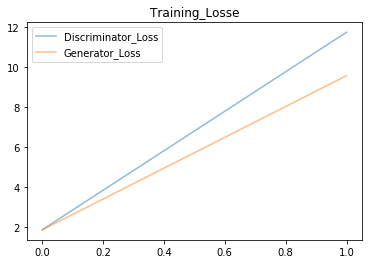

In [36]:
fig,ax=plt.subplots()
loss=np.array(losses)
plt.plot(losses[0],label="Discriminator_Loss",alpha=0.5)
plt.plot(losses[1],label="Generator_Loss",alpha=0.5)
plt.title("Training_Losse")
plt.legend()

In [39]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255/2).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

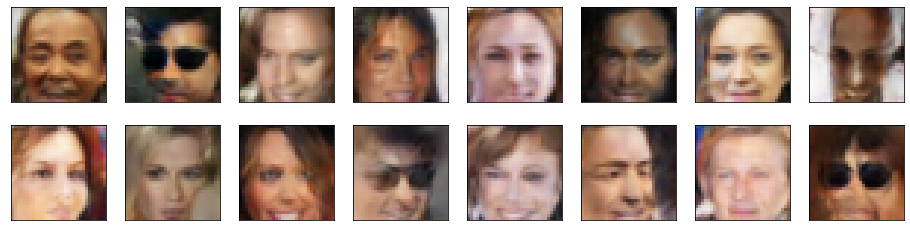

In [40]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)



_ = view_samples(-1, samples)

